<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Import-Packages-+-Data" data-toc-modified-id="Import-Packages-+-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Packages + Data</a></span></li><li><span><a href="#Explore-+-Clean-Data" data-toc-modified-id="Explore-+-Clean-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Explore + Clean Data</a></span><ul class="toc-item"><li><span><a href="#Explore-Country-Metrics" data-toc-modified-id="Explore-Country-Metrics-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Explore Country Metrics</a></span></li><li><span><a href="#Check-For-Null-Values" data-toc-modified-id="Check-For-Null-Values-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Check For Null Values</a></span></li><li><span><a href="#Check-For-Duplicates" data-toc-modified-id="Check-For-Duplicates-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Check For Duplicates</a></span></li><li><span><a href="#Cancelled-Orders" data-toc-modified-id="Cancelled-Orders-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Cancelled Orders</a></span></li><li><span><a href="#Add-TotalPrice-Column" data-toc-modified-id="Add-TotalPrice-Column-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Add TotalPrice Column</a></span></li><li><span><a href="#RFM-Variables" data-toc-modified-id="RFM-Variables-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>RFM Variables</a></span></li><li><span><a href="#Summary-Statistics" data-toc-modified-id="Summary-Statistics-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Summary Statistics</a></span></li></ul></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Future Work</a></span></li></ul></div>

# Intro

We're going to do an RFM analysis. RFM stands for Recency, Frequency and Monetary Value. We are then going to segment customers based on rankings in these three categories. We will use K-Means Clustering to segment the customers. By having these groups identified, we can target our marketing efforts with customers to increase revenue while retaining customers. (Add detail with this.)

**Recency** is how recently a customer made a purchase. 

**Frequency** is how often a customer makes a purchase. 

**Monetary** Value represents the amount of money a customer spent in a given time. 

# Import Packages + Data

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import data & convert to df
data = pd.read_excel('Data/Online_Retail.xlsx')
df = pd.DataFrame(data)

# Preview
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We can see here there are multiple items and quantities purchased on each invoice. I will create another column that shows total spent on each item, so Quantity * UnitPrice. That way we can group by invoice number, customer, etc. and see the total they spent per invoice and item.

We're also going to be adding Recency, Frequency and Monetary columns so we can conduct an RMF analysis and segment customers that way as well. 

Let's take a look at some of the basics before we hop into it. 

# Explore + Clean Data

In [3]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**InvoiceNo** is currently an object. I'm going to change that to an integer so we'll be able to group by invoice number. 

**StockCode** can stay an object, I'm guessing it's a string. 

It's great that **InvoiceDate** is already in datetime format, because we can peak at some time series in the EDA to see if we can collect any further insights. 

## Explore Country Metrics

How many countries are there?

In [4]:
len(df.Country.unique())

38

How many unique customers per country?

In [74]:
# Preview first 20 (out of 38)
df.groupby(['Country'])['CustomerID'].nunique().sort_values(ascending=False).head(20)

Country
United Kingdom     3950
Germany              95
France               87
Spain                31
Belgium              25
Switzerland          21
Portugal             19
Italy                15
Finland              12
Austria              11
Norway               10
Channel Islands       9
Netherlands           9
Denmark               9
Australia             9
Cyprus                8
Sweden                8
Japan                 8
Poland                6
Canada                4
Name: CustomerID, dtype: int64

We can see the UK has the most customers by a lot. Now I'm curious to see which countries have NaN values for CustomerID.

Another thing to note is that most of the orders come from the UK. Since this is an online retailer, and upon further exploration of the dataset, it seems perhaps a wholesaler (large volume orders, similar style products e.g. plates, napkins, lunch bags, doilies, etc. with different lines), we will explore customers from all countries. This is most likely a B2B online retailer, so its customers are more niche than general. For all of these reasons, we will keep data from all countries. We can always come back and index just the UK if we'd like to.

In [111]:
# NaN CustomerID field for a given item in an order (out of ~500K)
df[df.CustomerID.isnull() == True].groupby(['Country']).size().sort_values(ascending = False)


Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
dtype: int64

It looks like the CustomerID column with NaN values for some orders are distributed pretty evenly. This could be calculated precisely, however its effect doesn't seem to be isolated to any particular country. It's much higher for the United Kingdom, however the UK also has the most instances overall by a significant amount. 

## Check For Null Values

In [116]:
# Check for missing values

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

It looks like we have a good amount of Null values for **CustomerID** and **Description**. Let's see how much of the total this accounts for.

In [117]:
# Description
print('Description Percent Null Values:')
print(f"{((df.Description.isnull().sum())/len(df.Description)*100).round(4)} % \n")

# CustomerID
print('CustomerID Percent Null Values:')
print(f"{((df.CustomerID.isnull().sum())/len(df.CustomerID)*100).round(4)} % \n")

print('==============================')

Description Percent Null Values:
0.2683 % 

CustomerID Percent Null Values:
24.9267 % 



The number of missing values for the **Description** column is small, however for the **CustomerID** column it is large at almost 25%. I'm curious how many customers there were. Let's take a look at the number of unique values.

In [118]:
# Unique CustomerIDs

print(f'No. of unique CustomerIDs: \n{len(df.CustomerID.value_counts())}')

No. of unique CustomerIDs: 
4372


Since we still have data from over 4,300 customers, and we don't have any way of identifying the customers with the Null **CustomerID** field, it only makes sense to remove them. 

Since this is an RMF Analysis, we don't require the product descriptions. However, for future work in identifying any trends of products and categories each group desires, we would require this information. For such an analysis we could impute or simply drop as it represents only a fraction of a percent of the dataset.

In [119]:
# Drop rows w/null fields
df = df[df['CustomerID'].notna()]

In [120]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

It looks like dropping the null CustomerID data also removed the null Descriptions data. Well that worked out perfectly. 

I'm curious if the nulls were from any particular country, as almost 25% of the data had nulls, this is a significant amount of data and does have the potential to skew the true RMF data for a customer. 

## Check For Duplicates

In [126]:
# Preview duplicates
display(df[df.duplicated()].head())
display(df[df.duplicated()].tail())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom
541701,581538,23343,JUMBO BAG VINTAGE CHRISTMAS,1,2011-12-09 11:34:00,2.08,14446.0,United Kingdom


We're essentially just looking at the head and the tail, however I don't see any duplicates. Let's take a closer look.

In [130]:
df[df.InvoiceNo == 536412].duplicated().tail(10)

612    False
613    False
614    False
615    False
616     True
617     True
618     True
619    False
620     True
621    False
dtype: bool

In [131]:
df.iloc[615:622]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
615,536412,85184C,S/4 VALENTINE DECOUPAGE HEART BOX,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
616,536412,21708,FOLDING UMBRELLA CREAM POLKADOT,1,2010-12-01 11:49:00,4.95,17920.0,United Kingdom
617,536412,22900,SET 2 TEA TOWELS I LOVE LONDON,2,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
618,536412,21706,FOLDING UMBRELLA RED/WHITE POLKADOT,1,2010-12-01 11:49:00,4.95,17920.0,United Kingdom
619,536412,22988,SOLDIERS EGG CUP,6,2010-12-01 11:49:00,1.25,17920.0,United Kingdom
620,536412,85184C,S/4 VALENTINE DECOUPAGE HEART BOX,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
621,536412,20750,RED RETROSPOT MINI CASES,1,2010-12-01 11:49:00,7.95,17920.0,United Kingdom


None of these seem to be duplicates, so we're going to leave these here. Update: upon further research it seemed other users have had similar issues with df.duplicates( ), it seems when certain conditions are met with the dataset. 

## Cancelled Orders

Cancelled orders have a negative value for Quantity. 

In [136]:
df[df.Quantity < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


It loooks like negative quantity orders have a 'C' before the InvoiceNo. I checked the dataset description, and it turns out these are cancelled orders. So, we would ideally remove the initial orders associated with each one.

My initial thought was that I could look up the number after the C, however they don't seem to show up. They do however seem to still be associated with the CustomerID, so for now, I'm going to leave them. We want to include returns a customer makes in the total value they bring to the company, as leaving this out would create a false representation of the customer.

In [143]:
df[df.CustomerID == 17315]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
34510,C539402,21845,DAIRY MAID STRIPE MUG,-14,2010-12-17 12:19:00,2.95,17315.0,United Kingdom
34511,C539402,22488,NATURAL SLATE RECTANGLE CHALKBOARD,-1,2010-12-17 12:19:00,1.65,17315.0,United Kingdom
34512,C539402,21527,RED RETROSPOT TRADITIONAL TEAPOT,-1,2010-12-17 12:19:00,6.95,17315.0,United Kingdom
34524,539404,21528,DAIRY MAID TRADITIONAL TEAPOT,1,2010-12-17 12:24:00,6.95,17315.0,United Kingdom
34525,539404,22720,SET OF 3 CAKE TINS PANTRY DESIGN,1,2010-12-17 12:24:00,4.95,17315.0,United Kingdom
...,...,...,...,...,...,...,...,...
537797,581345,22151,PLACE SETTING WHITE HEART,24,2011-12-08 12:15:00,0.42,17315.0,United Kingdom
537798,581345,22698,PINK REGENCY TEACUP AND SAUCER,9,2011-12-08 12:15:00,2.95,17315.0,United Kingdom
537799,581345,22699,ROSES REGENCY TEACUP AND SAUCER,10,2011-12-08 12:15:00,2.95,17315.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


We want to include all purchases, cancelled orders and discounts given (I saw a discount present within a customer's order) so we can get a full and accurate picture of each customer.

## Add TotalPrice Column

In [163]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [147]:
df.describe().round(2)

,Quantity,UnitPrice,CustomerID,TotalPrice
count,406829.00,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69,20.40
std,248.69,69.32,1713.60,427.59
min,-80995.00,0.00,12346.00,-168469.60
25%,2.00,1.25,13953.00,4.20
50%,5.00,1.95,15152.00,11.10
75%,12.00,3.75,16791.00,19.50
max,80995.00,38970.00,18287.00,168469.60


## RFM Variables

Now that we've cleaned our data, we're going to add in Recency, Frequency and Monetary Value.

**Recency**: First, we'll find the most recent order, and use that as the point to calculate recency from. Then We'll calculate **Frequency** and **Monetary** Value. 

In [177]:
# Import datetime
import datetime as dt

# Find most recent order
max(df.InvoiceDate)

Timestamp('2011-12-09 12:50:00')

We'll round up to the 10th. 

In [171]:
# Recent date to calculate recency
recent_dt = dt.datetime(2011,12,10)

In [198]:
# Calculate Recency, Frequency, and Monetary Value
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (recent_dt - x.max()).days, 
                                    'InvoiceNo': lambda x: len(x), 
                                    'TotalPrice': lambda x: x.sum()})

# Change type to integer to use in calculations
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)

# New df, new columns labeled as R,F, & M
rfm.rename(columns={'InvoiceDate': 'recency',
                    'InvoiceNo': 'frequency',
                    'TotalPrice': 'monetary_value'}, inplace=True)

We're now going to remove any customers with Monetary Value less than zero, as these would indicate customers who cancelled an order, and haven't made more substantial orders within the time frame we are observing. 

In [199]:
# How many customers have negative monetary value
print(f"Customers w/Monetary Value < $0: \n{(len(rmf[rmf.monetary_value < 0])/len(rmf)*100):.2f}%")

Customers w/Monetary Value < $0: 
1.01%


In [201]:
# Only keep for positive monetary value
rfm = rfm[rfm.monetary_value > 0]

In [205]:
rfm.describe().round(2)

,recency,frequency,monetary_value
count,4320.00,4320.00,4320.00
mean,89.89,94.05,1924.37
std,99.14,233.67,8264.94
min,0.00,1.00,0.00
25%,16.00,18.00,302.44
50%,49.00,42.00,657.85
75%,138.00,102.25,1626.26
max,373.00,7983.00,279489.02


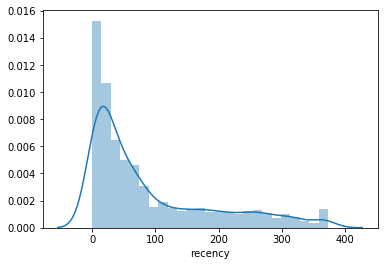

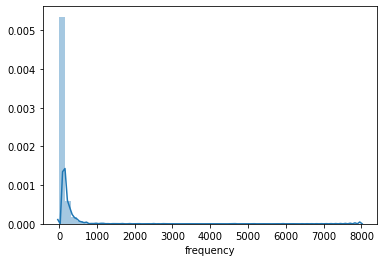

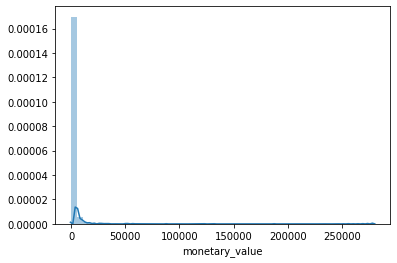

In [209]:
rmf_vars = ['recency', 'frequency', 'monetary_value']
for rmf_var in rmf_vars:
    sns.distplot(rfm[rmf_var])
    plt.show()

## Summary Statistics

In [202]:
# Summary statistics
df.describe().round(2)

,Quantity,UnitPrice,CustomerID,TotalPrice
count,406829.00,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69,20.40
std,248.69,69.32,1713.60,427.59
min,-80995.00,0.00,12346.00,-168469.60
25%,2.00,1.25,13953.00,4.20
50%,5.00,1.95,15152.00,11.10
75%,12.00,3.75,16791.00,19.50
max,80995.00,38970.00,18287.00,168469.60


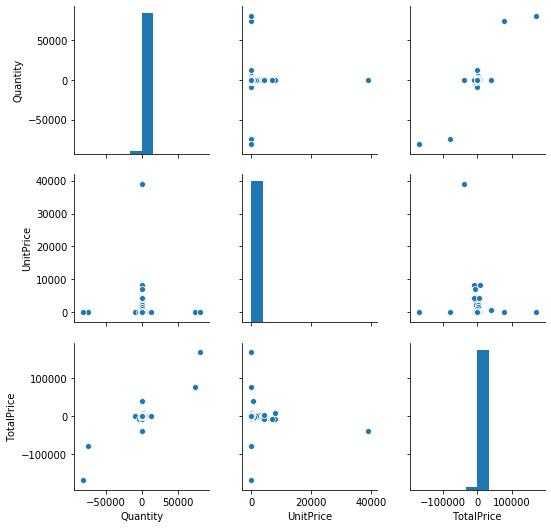

In [158]:
# Pairplot
sns.pairplot(df[['Quantity','UnitPrice','TotalPrice']]);

In [156]:
# Correlation matrix
df[['Quantity','UnitPrice','TotalPrice']].corr().round(4)

,Quantity,UnitPrice,TotalPrice
Quantity,1.0000,-0.0012,0.9161
UnitPrice,-0.0012,1.0000,-0.1293
TotalPrice,0.9161,-0.1293,1.0000


There is a weak correlation between UnitPrice and TotalPrice and a weak (yet stronger than the former correlation) between UnitPrice and Quantity. 

# Future Work

We can see there are many categories of products, such as napkins, aprons, notebooks, water bottles, lunch bags, etc. And across those categories there are many different lines of products, such as 'SPACE BOY', 'DOLLY GIRL', 'CIRCUS PARADE', 'CHARLIE + LOLA', and even 'BABUSHKA'. 

Greater insights could be attained by adding categories and lines as new columns. This would be somewhat time intensive, however it could support more targeted advertising directly to its current customers, which would increase sales/revenue, customer experience, engagement and overall CLV. It could also support targeted digital advertising such as Facebook and Google Ads. 

It the retailer doesn't already have it in place, they could add a recommendation system to increase price per transaction, revenue and customer lifetime values. 